# Binary classification with the crabs data

The package is designed to handle models of the following general form
$$\begin{aligned}
\mathbf{y} \ |\ \mathbf{f}, \theta &\sim  \prod_{i=1}^n p(y_i \ | \ f_i,\theta), \\
    \mathbf{f} \ | \ \theta &\sim \mathcal{GP}\left(m_{\theta}(\mathbf{x}), k_{\theta}(\mathbf{x}, \mathbf{x}')\right),\\
      \theta &\sim p(\theta), 
\end{aligned}$$
where $\mathbf{y}=(y_1,y_2,\ldots,y_n) \in \mathcal{Y}$ and $\mathbf{x} \in \mathcal{X}$ are the observations and covariates, respectively, and $f_i:=f(\mathbf{x}_i)$ is the latent function which we model with a Gaussian process prior. We assume that the responses $\mathbf{y}$ are independent and identically distributed and as a result the likelihood $p(\mathbf{y} \ | \ \mathbf{f}, \theta)$, can be factorized over the observations. 

In the case where the observations are Gaussian distributed, the marginal likelihood and predictive distribution can be derived analytically. See the  [Regression notebook](https://github.com/STOR-i/GaussianProcesses.jl/blob/master/notebooks/Regression.ipynb) for an illustration.

In this example we show how the GP **Monte Carlo** function can be used for **supervised learning classification**. We use the Crab dataset from the R package MASS. In this dataset we are interested in predicting whether a crab is of colour form blue or orange. Our aim is to perform a Bayesian analysis and calculate the posterior distribution of the latent GP function $\mathbf{f}$ and model parameters $\theta$ from the training data $\{\mathbf{X}, \mathbf{y}\}$.

In [1]:
using GaussianProcesses, RDatasets
import Distributions:Normal
using Random
using Plots
gr()

Random.seed!(113355)

crabs = dataset("MASS","crabs");              # load the data 
crabs = crabs[shuffle(1:size(crabs)[1]), :];  # shuffle the data

crabs = crabs[1:div(end,2),:];
train = crabs[1:div(end,2),:];               # training data

y = Array{Bool}(undef,size(train)[1]);       # response
y[train[:,:Sp].=="B"].=0;                      # convert characters to booleans
y[train[:,:Sp].=="O"].=1;

X = convert(Matrix,train[:,4:end]);          # predictors

## Defining GPs

We assume a zero mean GP with a Matern 3/2 kernel. We use the automatic relevance determination (ARD) kernel to allow each dimension of the predictor variables to have a different length scale. As this is binary classifcation, we use the Bernoulli likelihood, 

$$
y_i \sim \mbox{Bernoulli}(\Phi(f_i))
$$
where $\Phi: \mathbb{R} \rightarrow [0,1]$ is the cumulative distribution function of a standard Gaussian and acts as a squash function that maps the GP function to the interval [0,1], giving the probability that $y_i=1$. 

**Note** that `BernLik` requires the observations to be of type `Bool` and unlike some likelihood functions (e.g. student-t) does not contain any parameters to be set at initialisation.

In [2]:
#Select mean, kernel and likelihood function
mZero = MeanZero();                # Zero mean function
kern = Matern(3/2,zeros(5),0.0);   # Matern 3/2 ARD kernel (note that hyperparameters are on the log scale)
lik = BernLik();                   # Bernoulli likelihood for binary data {0,1}

We fit the GP using the general `GP` function. This function is a shorthand for the `GPA` function which is used to generate **approximations** of the latent function when the **likelihood is non-Gaussian**. 

In [3]:
#TODO: Probably don't need separate structs for mcmc and svgd object
gp_mcmc = GP(X',y,mZero,kern,lik)      # Fit the Gaussian process model
gp_svgd = GP(X',y,mZero,kern,lik)

GP Approximate object:
  Dim = 5
  Number of observations = 50
  Mean function:
    Type: MeanZero, Params: Float64[]
  Kernel:
    Type: Mat32Ard{Float64}, Params: [-0.0, -0.0, -0.0, -0.0, -0.0, 0.0]
  Likelihood:
    Type: BernLik, Params: Any[]
  Input observations = 
[16.2 11.2 … 16.2 15.6; 13.3 10.0 … 15.2 14.0; … ; 41.7 26.9 … 40.1 35.3; 15.4 9.4 … 13.9 13.8]
  Output observations = Bool[0, 0, 0, 0, 1, 1, 0, 1, 1, 1  …  1, 1, 0, 0, 0, 1, 0, 0, 0, 1]
  Log-posterior = -80.604

### Setting Priors

We assign `Normal` priors from the `Distributions` package to each of the Matern kernel parameters. If the mean and likelihood function also contained parameters, then we could set these priors in the same using `gp.m` and `gp.lik` in place of `gp.k`, respectively.

In [4]:
set_priors!(gp_mcmc.kernel,[Normal(0.0,2.0) for i in 1:6])
set_priors!(gp_svgd.kernel,[Normal(0.0,2.0) for i in 1:6])

6-element Array{Normal{Float64},1}:
 Normal{Float64}(μ=0.0, σ=2.0)
 Normal{Float64}(μ=0.0, σ=2.0)
 Normal{Float64}(μ=0.0, σ=2.0)
 Normal{Float64}(μ=0.0, σ=2.0)
 Normal{Float64}(μ=0.0, σ=2.0)
 Normal{Float64}(μ=0.0, σ=2.0)

### Posterior sampling

Samples of the latent function $f,\theta \ | \ X,y$ are drawn using MCMC sampling. By default, the `mcmc` function uses the Hamiltonian Monte Carlo algorithm. Unless defined, the default settings for the MCMC sampler are: 1,000 iterations with no burn-in phase or thinning of the Markov chain. 

In [5]:
samples = mcmc(gp_mcmc; nIter=10000, burn=1000, thin=10);

Number of iterations = 10000, Thinning = 10, Burn-in = 1000 
Step size = 0.100000, Average number of leapfrog steps = 9.970200 
Number of function calls: 99703
Acceptance rate: 0.438500 


We test the predictive accuracy of the fitted model against a hold-out dataset

In [6]:
test = crabs[div(end,2)+1:end,:];          # select test data

yTest = Array{Bool}(undef,size(test)[1]);   # test response data
yTest[test[:,:Sp].=="B"].=0;                  # convert characters to booleans
yTest[test[:,:Sp].=="O"].=1;

xTest = convert(Matrix,test[:,4:end]);

Using the posterior samples $\{f^{(i)},\theta^{(i)}\}_{i=1}^N$ from $p(f,\theta \ | \ X,y)$ we can make predictions $\hat{y}$ using the `predict_y` function to sample predictions conditional on the MCMC samples.

In [7]:
mcmc_mean = Array{Float64}(undef,size(samples,2),size(xTest,1));

for i in 1:size(samples,2)
    set_params!(gp_mcmc,samples[:,i])
    update_target!(gp_mcmc)
    mcmc_mean[i,:] = predict_y(gp_mcmc,xTest')[1]
end

For each of the posterior samples we plot the predicted observation $\hat{y}$ (given as lines) and overlay the true observations from the held-out data (circles).

In [8]:
pm1 = plot(mcmc_mean',leg=false,html_output_format=:png, alpha=0.01, color="blue", title="MCMC posterior mean")
pm1 = scatter!(yTest);

## Inference through SVGD

In [9]:
particles = svgd(gp_svgd;nIter=10000, nParticles=50, ε=0.1);

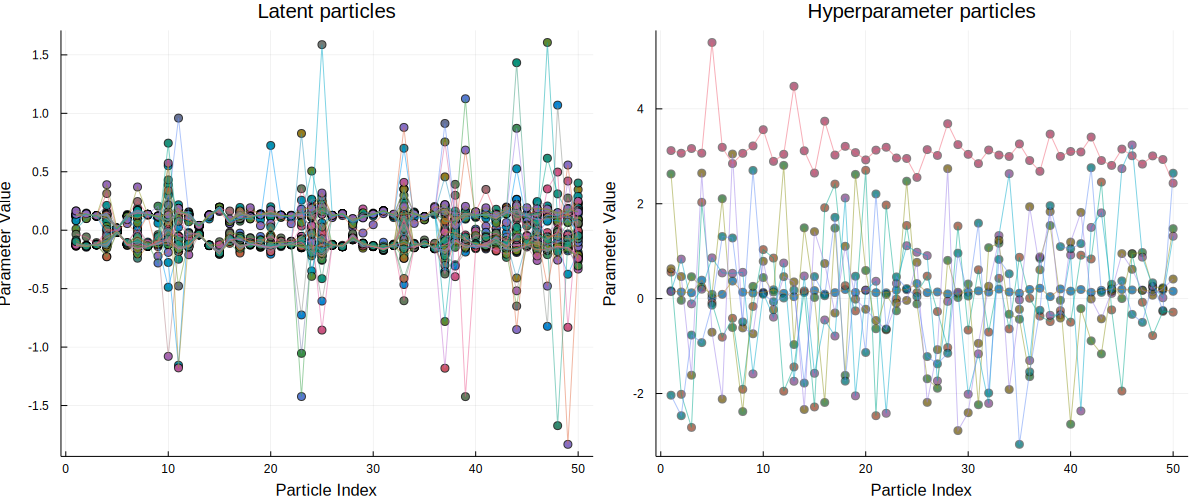

In [10]:
p1 = scatter(particles[1:50, :]', legend=false, title="Latent particles", alpha = 0.8, xlabel="Particle Index", ylabel="Parameter Value")
p1 = plot!(particles[1:50, :]', alpha = 0.5)
p2 = scatter(particles[50:end, :]', legend=false, title="Hyperparameter particles", alpha = 0.5, xlabel="Particle Index", ylabel="Parameter Value")
p2 = plot!(particles[50:end, :]', alpha = 0.5)
plot(p1, p2, size=(1200, 500))

In [11]:
#Sample from the predictive - using SVGD
ySVGD = Array{Float64}(undef,size(particles,2),size(xTest,1));
for i in 1:size(particles,2)
    set_params!(gp_svgd, particles[:,i])         # Set the GP parameters to the posterior values
    update_target!(gp_svgd)                   # Update the GP function with the new parameters
    ySVGD[i,:] = predict_y(gp_svgd, xTest')[1] # Store the predictive mean
end

#Sample from the predictive - using MCMC
yMCMC = Array{Float64}(undef,size(samples,2),size(xTest,1));
for i in 1:size(samples,2)
    set_params!(gp_mcmc,samples[:,i])         # Set the GP parameters to the posterior values
    update_target!(gp_mcmc)                   # Update the GP function with the new parameters
    yMCMC[i,:] = predict_y(gp_mcmc, xTest')[1] # Store the predictive mean
end

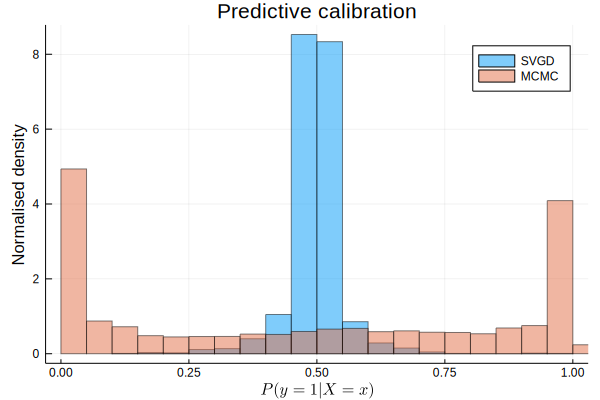

In [12]:
using LaTeXStrings
histogram(vec(ySVGD), normalize=true, bins=30, alpha=0.5, label="SVGD", title="Predictive calibration", xlabel=L"P(y=1|X=x)", 
    ylabel="Normalised density", xlim=[0, 1])
histogram!(vec(yMCMC), normalize=true, bins=30, alpha=0.5, label="MCMC")

In [19]:
using StatsBase

SVGD_preds = Array{Float64}(undef,1 ,size(ySVGD, 2));
for i in 1:size(ySVGD, 2)
    SVGD_preds[1, i] = StatsBase.mode(round.(ySVGD[:, i]))
end

MCMC_preds = Array{Float64}(undef,1 ,size(yMCMC, 2));
for i in 1:size(yMCMC, 2)
    MCMC_preds[1, i] = StatsBase.mode(round.(yMCMC[:, i]))
end

## Predictive Accuracy

In [31]:
rmse(pred, truth) = sqrt(mean((truth.-pred').^2))
acc(pred, truth) = 100*sum(pred .== reshape(truth, size(pred)))/size(pred, 2)

println("SVGD Accuracy: ", acc(SVGD_preds, yTest))
println("MCMC Accuracy: ", acc(MCMC_preds, yTest))

SVGD Accuracy: 78.0
MCMC Accuracy: 80.0


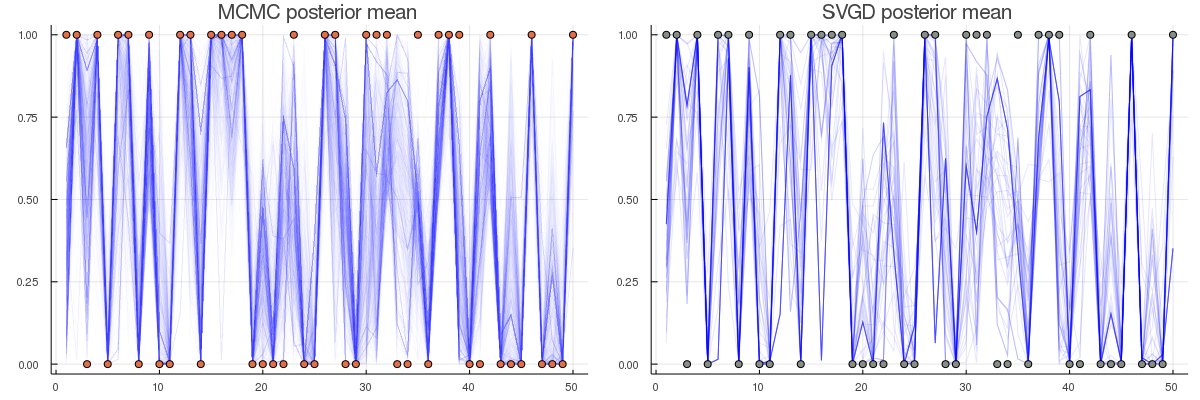

In [32]:
svgd_mean = Array{Float64}(undef,size(particles,2),size(xTest,1));

for i in 1:size(particles, 2)
    set_params!(gp_svgd,samples[:,i])
    update_target!(gp_svgd)
    svgd_mean[i,:] = predict_y(gp_svgd, xTest')[1]
end

pm2 = plot(svgd_mean',leg=false,html_output_format=:png, alpha=0.1, color="blue", title="SVGD posterior mean")
pm2 = scatter!(yTest)
plot(pm1, pm2, size=(1200, 400))

## Inspect parameter values

In [33]:
posterior_vals = Array{Float64}(undef, 2, size(samples, 1))
posterior_vars = Array{Float64}(undef, 2, size(samples, 1))

# for (i, j) in zip(mean(samples, dims=2), mean(particles, dims=2))
    
for i in 1:size(samples, 1)
    posterior_vals[:, i] = [mean(samples[i, :]), mean(particles[i, :])]
    posterior_vars[:, i] = [StatsBase.var(samples[i, :]), StatsBase.var(particles[i, :])]
end

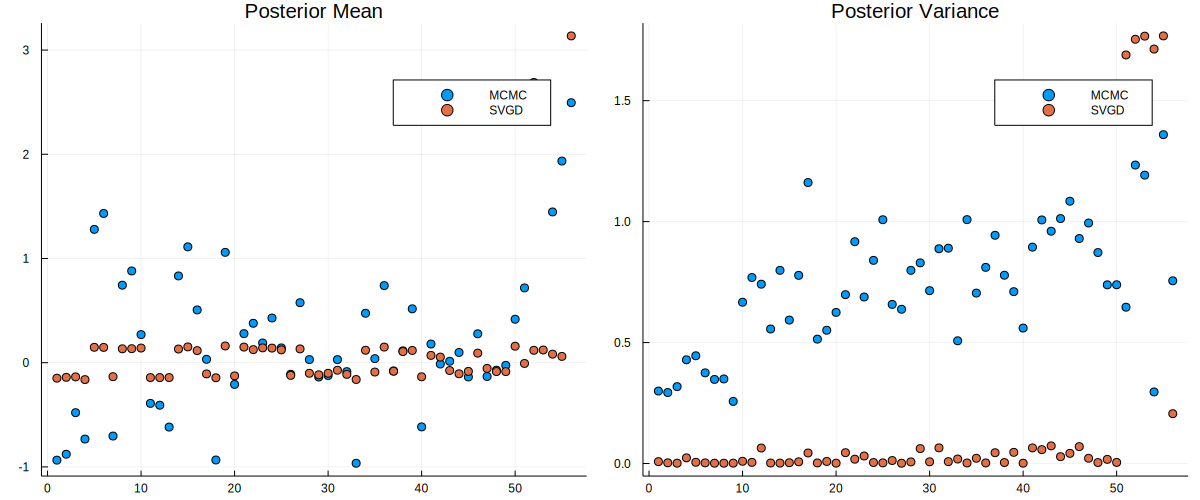

In [34]:
pos1 = scatter(posterior_vals', label=["MCMC" "SVGD"], title= "Posterior Mean")
pos2 = scatter(posterior_vars', label=["MCMC" "SVGD"], title="Posterior Variance")
plot(pos1, pos2, size=(1200, 500))